# Preprocessing of Dataset


TODO:
1. Import all required libraries
2. Download mnist muse dataset
3. Resample data
4. Perform similar operations on mindwave dataset


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time
from scipy.fft import fft, ifft
from scipy import interpolate

### Data Cleaning & Pre-Processing

Replace mnist_path with the location of the dataset in your system.

create two dfs one consisting data from FP1 and FP2 channels then combine them

In [3]:
mnist_path = r"C:\Users\kamat\Downloads\MWData\MWData\MW.csv"

# Load the file into a pandas DataFrame
df =pd.read_csv(mnist_path)
df.columns = ['id', 'event_id', 'device', 'channel', 'code', 'size', 'data']

#  convert each comma-separated string in the "data" column of a DataFrame df into a list of floats.(use apply and lambda)

df["data"] =df["data"].apply(lambda str1:[float(x) for x in str1.split(",") if x.strip() != "" and x.strip()!="-"])

# Display the first few rows of the DataFrame
print(df.head())

   id  event_id device channel  code  size  \
0   0         0     MW     FP1     0  1017   
1   1         1     MW     FP1     1   889   
2   2         2     MW     FP1     4  1017   
3   3         3     MW     FP1     1  1017   
4   4         4     MW     FP1     8   952   

                                                data  
0  [38.0, 48.0, 51.0, 44.0, 48.0, 56.0, 56.0, 41....  
1  [83.0, 74.0, 65.0, 65.0, 66.0, 55.0, 43.0, 25....  
2  [19.0, 10.0, -2.0, -9.0, -5.0, 3.0, 8.0, 7.0, ...  
3  [17.0, 29.0, 36.0, 26.0, 21.0, 17.0, 17.0, 13....  
4  [77.0, 74.0, 69.0, 70.0, 76.0, 75.0, 76.0, 75....  


#### Resampling the data

The sampling rate of an EEG device is often variable, leading to EEG data arrays with differing sizes, as evidenced in the size column. However, for consistent analysis, it is essential that all data arrays be of equal sizes. There are several approaches to achieve this uniformity, such as downsampling larger arrays, zero-padding smaller ones, or employing a specific resampling algorithm.

We will use linear interpolation to resample the arrays using —a method known for its efficiency and accuracy.

In [4]:
# Function to resample an array to the target length
def resample_array(array, target_length):
    # Create an array of indices for the input array
    input_indices = np.linspace(0, len(array)-1, len(array))

    # Create an array of indices for the resampled array
    resampled_indices =np.linspace(0,len(array)-1,target_length)

    # Create a linear interpolation function based on the input array
    interpolator =interpolate.interp1d(input_indices,array)

    # Use the interpolator to create the resampled array
    resampled_array =interpolator(resampled_indices)

    return resampled_array.tolist()

In [5]:
median_length=459
# Resample all the data arrays to the median length(use lambda function and apply)
df["resampled_data"] =df['data'].apply(lambda arr:resample_array(arr,median_length))

# Check the length of the resampled arrays
df["resampled_data_length"] = df["resampled_data"].apply(len)

# Display the first few rows of the updated DataFrame
df.head()


,id,event_id,device,channel,code,size,data,resampled_data,resampled_data_length
0,0,0,MW,FP1,0,1017,"[38.0, 48.0, 51.0, 44.0, 48.0, 56.0, 56.0, 41....","[38.0, 49.47161572052402, 51.493449781659386, ...",459
1,1,1,MW,FP1,1,889,"[83.0, 74.0, 65.0, 65.0, 66.0, 55.0, 43.0, 25....","[83.0, 65.55021834061135, 65.87772925764192, 4...",459
2,2,2,MW,FP1,4,1017,"[19.0, 10.0, -2.0, -9.0, -5.0, 3.0, 8.0, 7.0, ...","[19.0, -3.5283842794759814, -1.506550218340613...",459
3,3,3,MW,FP1,1,1017,"[17.0, 29.0, 36.0, 26.0, 21.0, 17.0, 17.0, 13....","[17.0, 33.81659388646288, 19.253275109170307, ...",459
4,4,4,MW,FP1,8,952,"[77.0, 74.0, 69.0, 70.0, 76.0, 75.0, 76.0, 75....","[77.0, 69.0764192139738, 75.8471615720524, 75....",459


We wont be working with the dataframe above, so lets convert the data from the resampled_array into an actual numpy array. Also lets get the code column out into a codes array.

In [6]:
data_array = np.array(df["resampled_data"].tolist())
codes = df['code'].tolist()



### Time-frequency calculation and plotting

Since the plan is to use a convolutional neural network, so the data needs to be converted to images. What better way then to create time-frequency plots of the data.

This is for your reference try to understand code written.

In [7]:
srate = 220
def time_frequency(data, cmwX, nKern):
    ''''
    Function to calculate time-frequency representation of multichannel data.

    Parameters:
    data : ndarray
        The EEG data, array of shape (channels, time).
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    channel_labels : list, optional
        The labels of the EEG channels. Must be the same length as the number of channels in the data.
        If not provided, no channel labels will be used.

    Returns:
    tf : ndarray
        The time-frequency representation of the data, array of shape (frequencies, time).
        This is the average power across all channels.
    '''

    # set up convolution parameters
    nData   = data.shape[1]
    nConv   = nData + nKern - 1
    halfwav = (nKern-1)//2

    # initialize time-frequency output matrix
    tf = np.zeros((data.shape[0], cmwX.shape[0], data.shape[1])) # channels X frequency X times

    # loop over channels
    for chani in range(data.shape[0]):

        # compute Fourier coefficients of EEG data
        eegX = fft(data[chani, :] , nConv)

        # perform convolution and extract power (vectorized across frequencies)
        as_ = ifft(cmwX * eegX[None, :], axis=1)
        as_ = as_[:, halfwav: -halfwav]
        tf[chani, :, :] = np.abs(as_) ** 2

    return tf


def get_cmwX(nData, freqrange=[1,40], numfrex=42):
    '''
    Function to calculate the Fourier coefficients of complex Morlet wavelets.

    Parameters:
    nData : int
        The number of data points.
    freqrange : list, optional
        The range of frequencies to consider. Defaults to [1,40].
    numfrex : int, optional
        The number of frequencies between the lowest and highest frequency. Defaults to 42.

    Returns:
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    frex : ndarray
        The array of frequencies.
    '''
    pi = np.pi
    wavtime = np.arange(-2,2-1/srate,1/srate)
    nKern = len(wavtime)
    nConv = nData + nKern - 1
    frex = np.linspace(freqrange[0],freqrange[1],numfrex)
   # create complex morlet wavelets array
    cmwX = np.zeros((numfrex, nConv), dtype=complex)

    # number of cycles
    numcyc = np.linspace(3,15,numfrex);
    for fi in range(numfrex):
        # create time-domain wavelet
        s = numcyc[fi] / (2*pi*frex[fi])
        twoSsquared = (2*s) ** 2
        cmw = np.exp(2*1j*pi*frex[fi]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )


        # compute fourier coefficients of wavelet and normalize
        cmwX[fi, :] = fft(cmw, nConv)
        cmwX[fi, :] = cmwX[fi, :] / max(cmwX[fi, :])

    return cmwX, nKern, frex



Note: You can play with different starting_freq and end_freq values here. This might lead to better model accuracies.

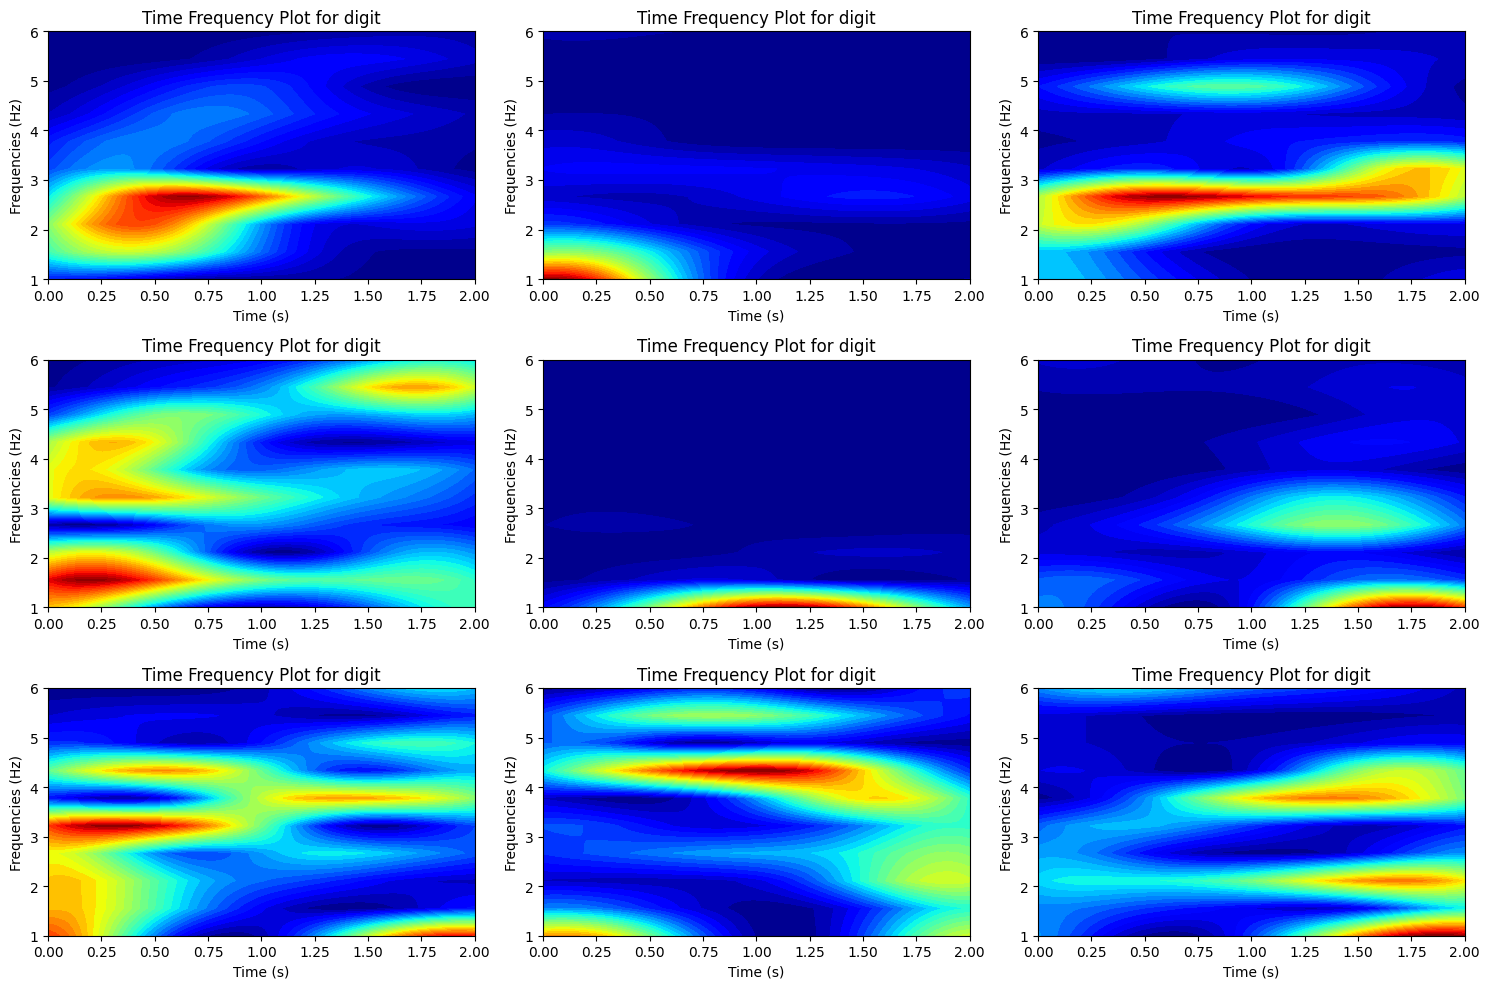

In [8]:
starting_freq = 1
end_freq = 6
num_frequencies = 10

#  Creates an array of time values starting from 0 to 2 seconds, with a total number of elements defined by median_length.
times = np.linspace(0,2,median_length)

nData = data_array.shape[1]
cmwX, nKern, frex = get_cmwX(nData, freqrange=[starting_freq, end_freq], numfrex=num_frequencies)
tf = time_frequency(data_array, cmwX, nKern)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i,ax in enumerate(axs.flat):
  x = random.randint(0, tf.shape[0])
  contour = ax.contourf(times, frex, tf[x,:,:], 40, cmap='jet')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Frequencies (Hz)')
  ax.set_title(f"Time Frequency Plot for {'non-digit' if codes[x] == -1 else 'digit'}")

fig.tight_layout()